In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import math
import itertools


In [20]:
# Set the style of seaborn plots
sns.set_theme(style='darkgrid')
mpl.rcParams['hatch.linewidth'] = 0.5

# Define full features, policy names, titles
featnames = {'lexdiv': 'Lexical Diversity',
            'sentcomp': 'Sentiment',
            'sim': 'Topical Similarity',
            'smog': 'Readability'}
polnames = {'chron': 'Chronological',
            'least-neg-abs': 'Rev. Downvotes',
            'neg-abs': 'Downvotes',
            'pos-abs': 'Upvotes',
            'pos-rel': 'Relative Votes',
            'rev-chron': 'Rev. Chronological',
            'pred-nb': 'Pred. Upvotes (NBR)',
            'pred-xgb': 'Pred. Upvotes (XGB)',            
            'pin-pred-lr': 'Pred. Editors\' Picks (LR)',
            'pin-pred-xgb': 'Pred. Editors\' Picks (XGB)',
            'random': 'Random',
            'policy_chron': 'Chronological',
            'policy_least-neg-abs': 'Rev. Downvotes',
            'policy_neg-abs': 'Downvotes',
            'policy_pos-abs': 'Upvotes',
            'policy_pos-rel': 'Relative Votes',
            'policy_rev-chron': 'Rev. Chronological',
            'policy_random': 'Random',
            'policy_pin-pred-lr': 'Pred. Editors\' Picks (LR)',
            'policy_pin-pred-xgb': 'Pred. Editors\' Picks (XGB)',
            'policy_pred-nb': 'Pred. Upvotes (NBR)',
            'policy_pred-xgb': 'Pred. Upvotes (XGB)',
            'replies_rh': 'Replies Hidden',
            'replies_rt': 'Reply Trees Shown',
            'replies_rl': 'Replies Loose',
            'replies hidden': 'Replies Hidden',
            'reply trees': 'Reply Trees Shown',
            'replies loose': 'Replies Loose',
            'pinned': 'Editors\' Picks Pinned',
            'not_pinned': 'Editors\' Picks Not Pinned'}
titles = {'10': 'First 10 Comments','N': 'Full Comment Discussion'}
repl = {'rh': 'Hidden',
        'rt': 'Trees',
        'rl': 'Loose'}
markers = {'Upvotes':'o',
            'Relative Votes':'o',
            'Downvotes':'o',
            'Rev. Downvotes':'o',
            'Chronological':'o',
            'Rev. Chronological':'o',
            'Pred. Editors\' Picks (LR)':'o',
            'Pred. Editors\' Picks (XGB)':'o',
            'Pred. Upvotes (NBR)':'o',
            'Pred. Upvotes (XGB)':'o',
            'Replies Hidden':'s',
            'Reply Trees Shown':'s',
            'Editors\' Picks Pinned':'D'}

# Function to parse policy elements from policy name
def policynameparse(x):
    if x.startswith('policy_'):
        x = x[7:]

    spl = x.split('_')
    policy = polnames[spl[0]]
    replies = repl[spl[-1]]
    pinned = 'Pinned' if 'pinned' in x else 'Not Pinned'

    return policy, replies, pinned

# Function to assign significance labels based on p-values
def txt(n):
    if n < .001:
        return '***'
    elif n < .01:
        return '**'
    elif n < .05:
        return '*'
    else:
        return '-'
    
# define order and position dictionaries
polorder = ['Upvotes', 'Relative Votes', 'Downvotes', 'Rev. Downvotes', 
       'Chronological', 'Rev. Chronological', 'Pred. Editors\' Picks (LR)',
       'Pred. Editors\' Picks (XGB)', 'Pred. Upvotes (NBR)', 'Pred. Upvotes (XGB)',
       'Replies Hidden', 'Reply Trees Shown', 'Editors\' Picks Pinned']
prodorder = list(itertools.product(polorder[:-3], polorder[-3:]))

featorder = ['Lexical Diversity', 'Sentiment', 'Topical Similarity', 'Readability']

pos_dict1 = {x: n for n, x in enumerate(polorder)}
pos_dict2 = {'Lexical Diversity': 0,
            'Sentiment': 1,
            'Topical Similarity': 2,
            'Readability': 3}
pos_dict3 = {x: n for n, x in enumerate(polorder[-3:])}

# Dictionary to map feature names to colors
color_dict = dict(zip(['Lexical Diversity', 'Sentiment', 'Topical Similarity',
                      'Readability'], [sns.color_palette("colorblind")[:4]]))

pal = sns.color_palette(["#69ef7b", "#284e37", "#aad0aa", "#44a42f", "#10eddc",
                         "#19477d", "#c697f4", "#762aac", "#40b8e1", "#8c2e63",
                         "#f764de", "#3f16f9", "#c0e15c"])

In [21]:
# Load data from regression analysis (R)

df_total = pd.read_csv('model_output/betareg.csv', index_col=0)
df_total['feature'] = df_total['feature'].str.replace('.', '-').apply(lambda x: polnames.get(x, x))
df_total['variable'] = df_total['variable'].map(featnames)
df_total['ci_lower_95'] = df_total['Estimate'] - 1.96 * df_total['Std. Error']
df_total['ci_upper_95'] = df_total['Estimate'] + 1.96 * df_total['Std. Error']
df_total['ci_lower_99'] = df_total['Estimate'] - 2.576 * df_total['Std. Error']
df_total['ci_upper_99'] = df_total['Estimate'] + 2.576 * df_total['Std. Error']


pdictr = {}
for n in ['10', 'N']:
    pdictr[n] = {}
    pdictr[n]['coef'] = df_total[df_total['n']==n][['feature', 'variable', 'Estimate']
                            ].rename(columns={'feature':'index', 'Estimate': 'value'})
    pdictr[n]['coef']['valuet'] = (np.exp(pdictr[n]['coef']['value']) - 1)/(np.exp(pdictr[n]['coef']['value']) + 1)

    pdictr[n]['pv'] = df_total[df_total['n']==n][['feature', 'variable', 'Pr(>|z|)']
                        ].rename(columns={'feature':'index', 'Pr(>|z|)': 'value'})
    pdictr[n]['pv']['valuet'] = pdictr[n]['pv']['value'].apply(txt)

    pdictr[n]['ci'] = df_total[df_total['n']==n][['feature', 'variable', 'ci_lower_95', 'ci_upper_95', 'ci_lower_99', 'ci_upper_99']
                        ].rename(columns={'feature':'index'})
    

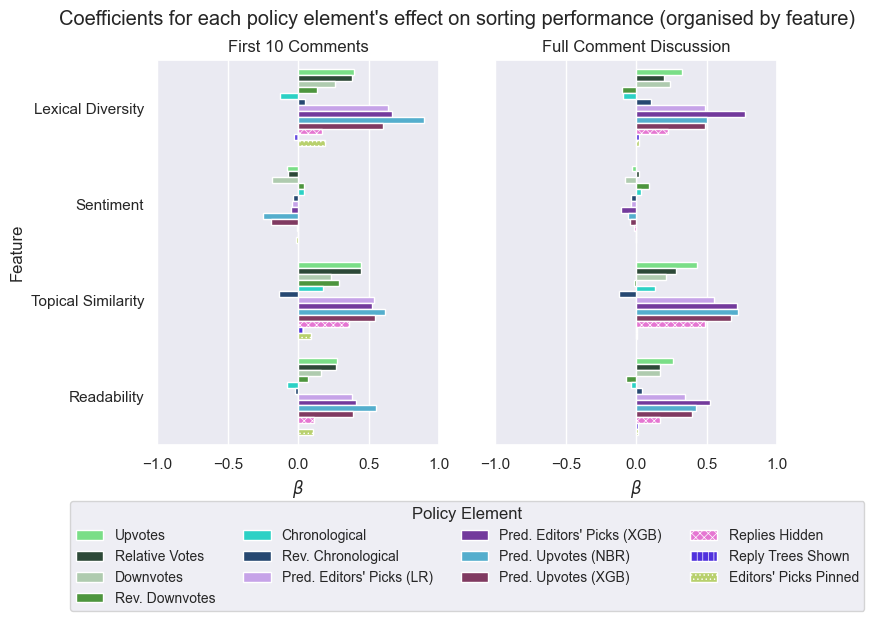

In [17]:
# Plot coefficients by feature

fig, axs = plt.subplots(1, 2, figsize=(8, 5), sharey=True)
shift = 0.1
off = 0.003
for n, (ncomments, pdictn) in enumerate(pdictr.items()):
    ax = axs[n]
    pdf = pdictn['coef']
    pdf = pdf[(pdf['index']!='(Intercept)')&(~pdf['index'].str.contains(':'))]
    pdf.set_index('index').loc[polorder].reset_index()
    pvdf = pdictn['pv']
    pvdf = pvdf[(pvdf['index']!='(Intercept)')&(~pvdf['index'].str.contains(':'))]
    pvdf.set_index('index').loc[polorder].reset_index()
    sns.barplot(data=pdf, x='value', y='variable', hue='index',
                palette=pal, hue_order=polorder,
                ax=axs[n])
    ax.set_xlabel(r'$\beta$')
    ax.set_xlim(-1, 1)
    ax.set_title(titles[ncomments])

    colors = [handle.get_fc()
                for handle in ax.get_legend_handles_labels()[0]]

    # change hatching
    for bar in ax.patches:
        if bar.get_fc() == colors[-1]:
            bar.set_hatch('....')
        elif bar.get_fc() == colors[-2]:
            bar.set_hatch('|||')
        elif bar.get_fc() == colors[-3]:
            bar.set_hatch('XXXX')
    if n:
        ax.legend(title='Policy Element', ncols=4, loc='lower center', bbox_to_anchor=(-0.1, -0.45),
                fontsize=10)
        
        ax.axes.get_yaxis().get_label().set_visible(False)
    else:
        ax.set_ylabel('Feature')
        ax.get_legend().remove()

    # add text from pvdf to corresponding bars
    # for i, row in pvdf.iterrows():
    #     if row['valuet'] != '-':
    #         va = 'bottom'
    #         yp = pos_dict2[row['variable']] + shift + (pos_dict1[row['index']]-6)/16
    #     else:
    #         va = 'bottom'
    #         yp = pos_dict2[row['variable']] + shift - 0.04 + (pos_dict1[row['index']]-6)/16

    #     lr = max(pdf[(pdf['index'] == row['index'])&(pdf['variable'] == row['variable'])]['value'].values[0], 0)
    #     ax.text(lr+off, yp, row['valuet'], ha='left', va=va, color='k')

fig.suptitle('Coefficients for each policy element\'s effect on sorting performance (organised by feature)')
plt.savefig('figs/coef_by_feature.pdf', bbox_inches='tight')
plt.savefig('figs/coef_by_feature.svg', bbox_inches='tight')
plt.show()

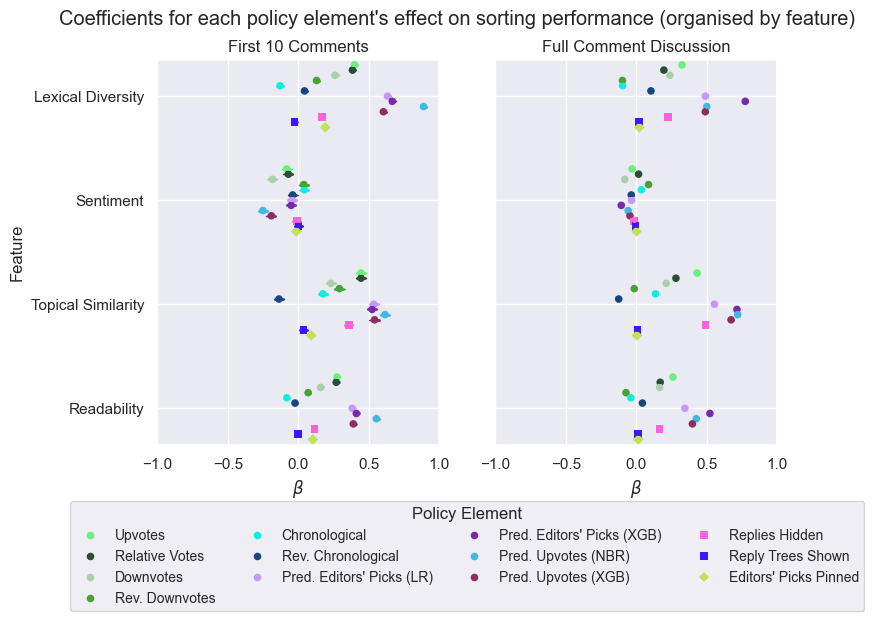

In [5]:
# Plot coefficients by feature with points

fig, axs = plt.subplots(1, 2, figsize=(8, 5), sharey=True)
shift = 0.1
off = 0.003
for n, (ncomments, pdictn) in enumerate(pdictr.items()):
    ax = axs[n]
    pdf = pdictn['coef']
    pdf = pdf[(pdf['index']!='(Intercept)')&(~pdf['index'].str.contains(':'))]
    pdf = pdf.set_index('index').loc[polorder].reset_index()
    pvdf = pdictn['pv']
    pvdf = pvdf[(pvdf['index']!='(Intercept)')&(~pvdf['index'].str.contains(':'))]
    pvdf = pvdf.set_index('index').loc[polorder].reset_index()
    cdf = pdictn['ci']
    cdf = cdf[(cdf['index']!='(Intercept)')&(~cdf['index'].str.contains(':'))]
    cdf = cdf.set_index('index').loc[polorder].reset_index()
    cdf['value'] = pdf['value']
    sns.scatterplot(data=pdf, x='value', y='variable', hue='index', style='index',
                    markers=markers, palette=pal, hue_order=polorder, lw=0, s=30,
                    ax=axs[n])
    # get points in ax
    points = ax.collections[0].get_offsets()
    # change y values of points by
    offset = 0.05
    offset_array = np.array([(x//4 - 6)*offset for x in range(52)])
    points[:,1] = points[:,1] + offset_array

    # add confidence intervals from cdf
    for i, row in cdf.iterrows():
        yy = pos_dict2[row['variable']] + (i//4 - 6)*offset
        ax.plot([row['ci_lower_95'], row['ci_upper_95']],
                [yy]*2,
                color=pal[i//4], lw=2)        
        ax.plot([row['ci_lower_99'], row['ci_upper_99']],
                [yy]*2,
                color=pal[i//4], lw=1)
        
    ax.set_xlabel(r'$\beta$')
    ax.set_xlim(-1, 1)
    ax.set_ylim(points[:,1].max() + offset, points[:,1].min() - offset)
    ax.set_title(titles[ncomments])

    if n:
        ax.legend(title='Policy Element', ncols=4, loc='lower center', bbox_to_anchor=(-0.1, -0.45),
                fontsize=10)
        
        ax.axes.get_yaxis().get_label().set_visible(False)
    else:
        ax.set_ylabel('Feature')
        ax.get_legend().remove()

fig.suptitle('Coefficients for each policy element\'s effect on sorting performance (organised by feature)')
plt.savefig('figs/coef_by_feature_points.pdf', bbox_inches='tight')
plt.savefig('figs/coef_by_feature_points.svg', bbox_inches='tight')
plt.show()

/var/folders/3m/k3bhjj_54975gvpvvrkv8x6w0000gn/T/ipykernel_28682/1298935269.py:13: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.barplot(data=pdf, x='value', y='index', hue='variable',
/var/folders/3m/k3bhjj_54975gvpvvrkv8x6w0000gn/T/ipykernel_28682/1298935269.py:13: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.barplot(data=pdf, x='value', y='index', hue='variable',


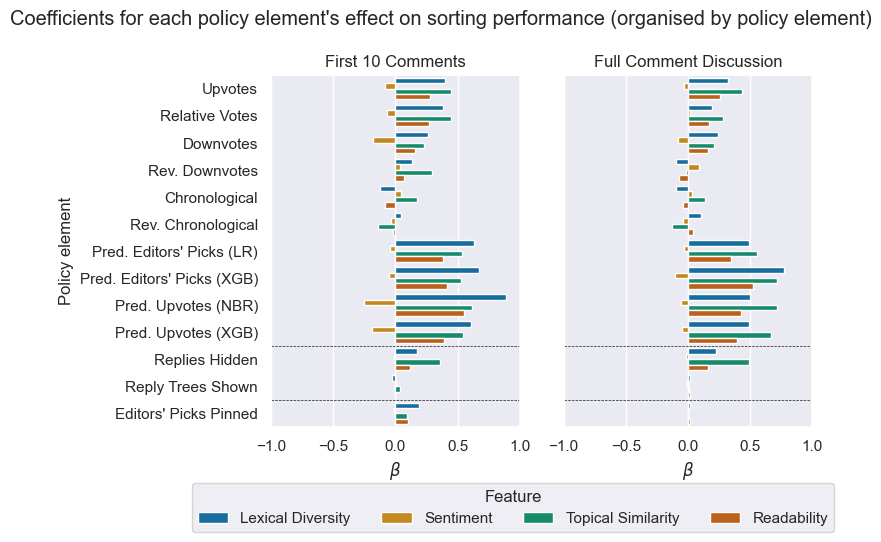

In [18]:
# Plot coefficients by policy element

fig, axs = plt.subplots(1, 2, figsize=(8, 5), sharey=True)
shift = 0.015
for n, (ncomments, pdictn) in enumerate(pdictr.items()):
    ax = axs[n]
    pdf = pdictn['coef']
    pdf = pdf[(pdf['index']!='(Intercept)')&(~pdf['index'].str.contains(':'))]
    pdf = pdf.set_index('index').loc[polorder].reset_index()
    pvdf = pdictn['pv']
    pvdf = pvdf[(pvdf['index']!='(Intercept)')&(~pvdf['index'].str.contains(':'))]
    pvdf = pvdf.set_index('index').loc[polorder].reset_index()
    sns.barplot(data=pdf, x='value', y='index', hue='variable',
                palette=sns.color_palette("colorblind"), hue_order=featorder,
                ax=axs[n])
    ax.axhline(9.5, c='k', lw=0.5, ls = '--')
    ax.axhline(11.5, c='k', lw=0.5, ls = '--')

    ax.set_xlabel(r'$\beta$')
    ax.set_xlim(-1, 1)
    ax.set_title(titles[ncomments])

    colors = [handle.get_fc()
                for handle in ax.get_legend_handles_labels()[0]]

    if n:
        ax.axes.get_yaxis().get_label().set_visible(False)
    else:
        ax.set_ylabel('Policy element')
    ax.get_legend().remove()

    #  add text from pvdf to corresponding bars
    # for i, row in pvdf.iterrows():
    #     if row['valuet'] != '-':
    #         va = 'bottom'
    #         yp = pos_dict1[row['index']] + shift + (pos_dict2[row['variable']])/4.5
    #     else:
    #         va = 'bottom'
    #         yp = pos_dict1[row['index']] + shift - 0.15 + (pos_dict2[row['variable']])/4.5
    #     lr = max(pdf[(pdf['index'] == row['index'])&(pdf['variable'] == row['variable'])]['value'].values[0], 0)
    #     ax.text(lr+off, yp, row['valuet'], ha='left', va=va, color='k')

handles = ax.get_legend_handles_labels()[0]
labels = ax.get_legend_handles_labels()[1]
fig.legend(handles, labels, title='Feature', loc='lower center', bbox_to_anchor=(0.59, -0.08), ncols=4)
fig.suptitle('Coefficients for each policy element\'s effect on sorting performance (organised by policy element)')
fig.tight_layout()
plt.savefig('figs/coef_by_policy.pdf', bbox_inches='tight')
plt.savefig('figs/coef_by_policy.svg', bbox_inches='tight')
plt.show()

/var/folders/3m/k3bhjj_54975gvpvvrkv8x6w0000gn/T/ipykernel_28682/4195999788.py:16: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(data=pdf, x='value', y='index', hue='variable', style='index',
/var/folders/3m/k3bhjj_54975gvpvvrkv8x6w0000gn/T/ipykernel_28682/4195999788.py:16: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(data=pdf, x='value', y='index', hue='variable', style='index',


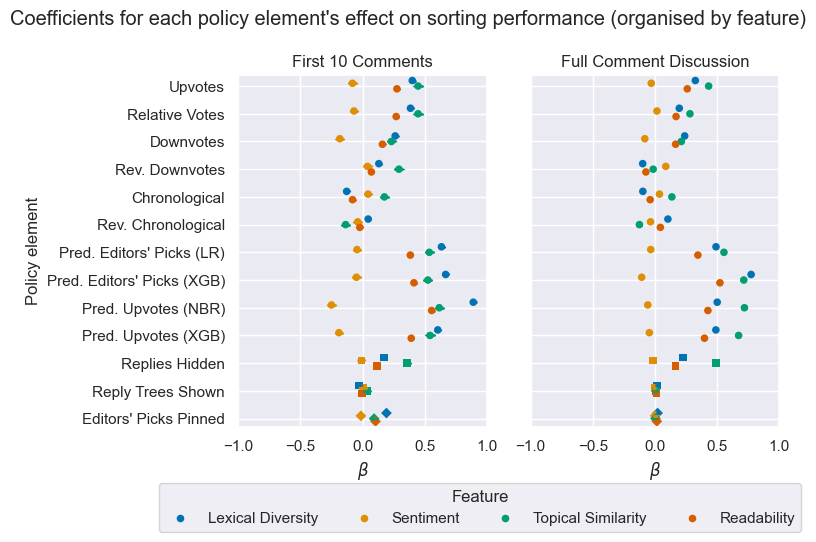

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(8, 5), sharey=True)
shift = 0.1
off = 0.003
for n, (ncomments, pdictn) in enumerate(pdictr.items()):
    ax = axs[n]
    pdf = pdictn['coef']
    pdf = pdf[(pdf['index']!='(Intercept)')&(~pdf['index'].str.contains(':'))]
    pdf = pdf.set_index('index').loc[polorder].reset_index()
    pvdf = pdictn['pv']
    pvdf = pvdf[(pvdf['index']!='(Intercept)')&(~pvdf['index'].str.contains(':'))]
    pvdf = pvdf.set_index('index').loc[polorder].reset_index()
    cdf = pdictn['ci']
    cdf = cdf[(cdf['index']!='(Intercept)')&(~cdf['index'].str.contains(':'))]
    cdf = cdf.set_index('index').loc[polorder].reset_index()
    cdf['value'] = pdf['value']
    sns.scatterplot(data=pdf, x='value', y='index', hue='variable', style='index',
                    markers=markers, palette=sns.color_palette("colorblind"), hue_order=featorder, lw=0, s=30,
                    ax=axs[n])
    # get points in ax
    points = ax.collections[0].get_offsets()
    # change y values of points by
    offset = 0.1
    offset_array = np.array([(x%4 - 2)*offset for x in range(52)])
    points[:,1] = points[:,1] + offset_array

    # add confidence intervals from cdf
    for i, row in cdf.iterrows():
        yy = pos_dict1[row['index']] + (i%4 - 2)*offset
        ax.plot([row['ci_lower_95'], row['ci_upper_95']],
                [yy]*2,
                color=sns.color_palette("colorblind")[i%4], lw=2)        
        ax.plot([row['ci_lower_99'], row['ci_upper_99']],
                [yy]*2,
                color=sns.color_palette("colorblind")[i%4], lw=1)
        
    ax.set_xlabel(r'$\beta$')
    ax.set_xlim(-1, 1)
    ax.set_ylim(points[:,1].max() + 2*offset, points[:,1].min() - 2*offset)
    ax.set_title(titles[ncomments])

    if n:
        ax.axes.get_yaxis().get_label().set_visible(False)
    else:
        ax.set_ylabel('Policy element')
    ax.get_legend().remove()

handles = ax.get_legend_handles_labels()[0][1:5]
labels = ax.get_legend_handles_labels()[1][1:5]
fig.legend(handles, labels, title='Feature', loc='lower center', bbox_to_anchor=(0.59, -0.08), ncols=4)

fig.suptitle('Coefficients for each policy element\'s effect on sorting performance (organised by feature)')
fig.tight_layout()
plt.savefig('figs/coef_by_feature_points.pdf', bbox_inches='tight')
plt.savefig('figs/coef_by_feature_points.svg', bbox_inches='tight')
plt.show()


/var/folders/3m/k3bhjj_54975gvpvvrkv8x6w0000gn/T/ipykernel_28682/3552903517.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf['policy'] = pdf['index'].str.split(':').str[0].map(polnames)
/var/folders/3m/k3bhjj_54975gvpvvrkv8x6w0000gn/T/ipykernel_28682/3552903517.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf['interaction'] = pdf['index'].str.split(':').str[1].map(polnames)
/var/folders/3m/k3bhjj_54975gvpvvrkv8x6w0000gn/T/ipykernel_28682/3552903517.py:21: SettingWithCopyWarning: 
A value is 

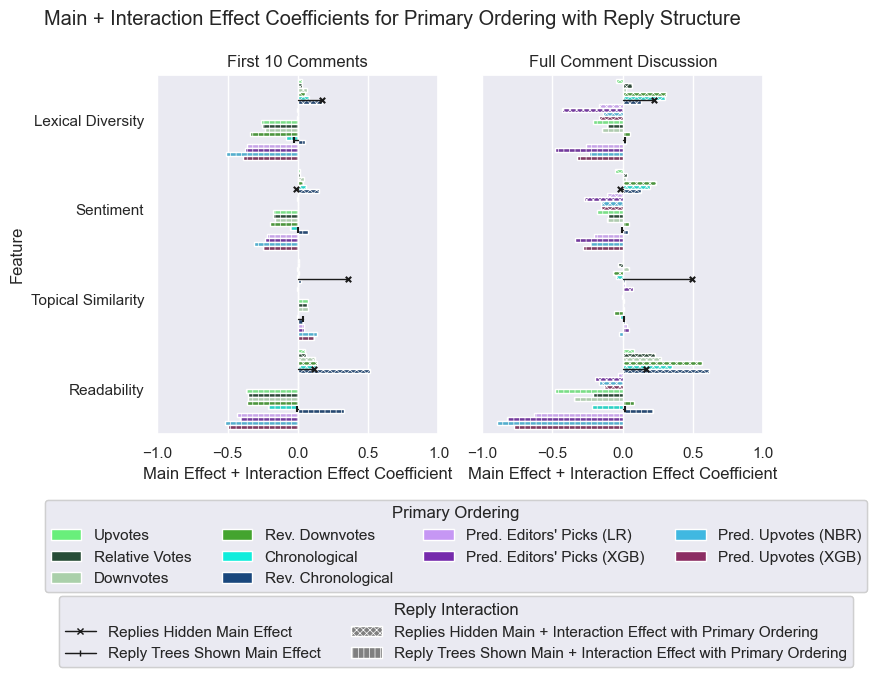

In [8]:
# Plot interaction effects

barsdict = {}
shift = 0.35
fig, axs = plt.subplots(1, 2, figsize=(8, 5), sharey=True)
for n, (ncomments, pdictn) in enumerate(pdictr.items()):
    ax = axs[n]
    pdf = pdictn['coef']
    pdfm = pdf[(pdf['index']!='(Intercept)')&(~pdf['index'].str.contains(':'))]
    pdf = pdf[(pdf['index']!='(Intercept)')&(pdf['index'].str.contains(':'))]
    pdf['policy'] = pdf['index'].str.split(':').str[0].map(polnames)
    pdf['interaction'] = pdf['index'].str.split(':').str[1].map(polnames)
    pdf = pdf.set_index(['policy', 'interaction']).loc[prodorder].reset_index()
    pn = pdictn['coef'].rename(columns={'index': 'policy'})
    pnn = (pn[pn['policy'].isin(polorder[-3:])].rename(
        columns={'policy': 'interaction'}).set_index(['interaction', 'variable'])['value']
        + pdf.set_index(['policy', 'interaction', 'variable'])['value']).reset_index()

    pvdf = pdictn['pv']
    pvdf = pvdf[(pvdf['index']!='(Intercept)')&(pvdf['index'].str.contains(':'))]
    pvdf['policy'] = pvdf['index'].str.split(':').str[0].map(polnames)
    pvdf['interaction'] = pvdf['index'].str.split(':').str[1].map(polnames)
    pvdf = pvdf.set_index(['policy', 'interaction']).loc[prodorder].reset_index()
    
    hatchdict = {0: 'XXXXX', 1: '|||'}
    for n_i, i in enumerate(['Replies Hidden', 'Reply Trees Shown']):
        figt, axt = plt.subplots(1, 1, figsize=(10, 10))
        pnni = pnn[pnn['interaction'] == i]
        sns.barplot(data=pnni, x='value', y='variable', hue='policy', palette=pal,
                    hue_order=polorder[:-3], hatch=hatchdict[n_i], width=0.9, ax=axt)

        axt.get_legend().remove()
        barsdict[i] = [mpatches.Rectangle((bar.get_x(), bar.get_y() + math.floor(nbar/10) + n_i*0.9 - 0.45), bar.get_width(), bar.get_height(), 
                                        fc=bar.get_facecolor(), hatch=bar.get_hatch())
                                        for nbar, bar in enumerate(sorted(sum([axt.get_children().copy()[8*n:8*n+4] for n in range(10)], []), key = lambda x: x.get_y()))]

        plt.close()

    # fig, ax = plt.subplots(1, 1, figsize=(10, 15))
    for k, v in barsdict.items():
        for bar in v:
            ax.add_patch(bar)    

    ax.set_xticks(np.arange(-1.5, 1.5, 0.5))
    # set yticklabels
    ax.set_yticks(range(0,8,2), labels=featorder)
    # remove y gridlines
    ax.yaxis.grid(False)


    for f in featorder:
        for r in ['Replies Hidden', 'Reply Trees Shown']:
            main = pn[(pn['policy'] == r)&(pn['variable'] == f)]['value'].iloc[0]
            yy = 2*featorder.index(f) + 0.9*(r == 'Reply Trees Shown') - 0.45
            ax.plot((0, main), (yy, yy),
                    color='k', lw=1, alpha=1)
            if r=='Replies Hidden':
                marker = 'x'
            else:
                marker = '|'
            ax.scatter((main,), (yy,),
                    color='k', alpha=1, s=15, marker=marker)

    ax.set_xlim(-1, 1)
    ax.set_ylim(7, -1)
    ax.set_xlabel('Main Effect + Interaction Effect Coefficient')
    ax.set_title(titles[ncomments])

# create colour legend
handles = [mpatches.Patch(facecolor=pal[i]) for i in range(12)]
labels = polorder[:-3]
l1 = fig.legend(handles, labels, title='Primary Ordering', loc='lower center', ncols=4,
                bbox_to_anchor=(0.58, -0.2))

# add hatch legend
handles = [mlines.Line2D([], [], color='k', marker='x', ms=5, lw=1),
            mlines.Line2D([], [], color='k', marker='|', ms=5, lw=1)] + [mpatches.Patch(facecolor='grey', hatch=hatchdict[i]) for i in range(2)]
labels = ['Replies Hidden Main Effect', 'Reply Trees Shown Main Effect',
          'Replies Hidden Main + Interaction Effect with Primary Ordering',
          'Reply Trees Shown Main + Interaction Effect with Primary Ordering']
l2 = fig.legend(handles, labels, title='Reply Interaction',  ncols=2, loc='lower center',
                bbox_to_anchor=(0.58, -0.35))

# add both legends to the same axes
ax.add_artist(l1)
ax.add_artist(l2)
axs[0].set_ylabel('Feature')

fig.suptitle('Main + Interaction Effect Coefficients for Primary Ordering with Reply Structure')
fig.tight_layout()
plt.savefig('figs/reply_int_coef.pdf', bbox_inches='tight')
plt.savefig('figs/reply_int_coef.svg', bbox_inches='tight')
fig.show()

/var/folders/3m/k3bhjj_54975gvpvvrkv8x6w0000gn/T/ipykernel_28682/4124571306.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf['policy'] = pdf['index'].str.split(':').str[0].map(polnames)
/var/folders/3m/k3bhjj_54975gvpvvrkv8x6w0000gn/T/ipykernel_28682/4124571306.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf['interaction'] = pdf['index'].str.split(':').str[1].map(polnames)
/var/folders/3m/k3bhjj_54975gvpvvrkv8x6w0000gn/T/ipykernel_28682/4124571306.py:21: SettingWithCopyWarning: 
A value is 

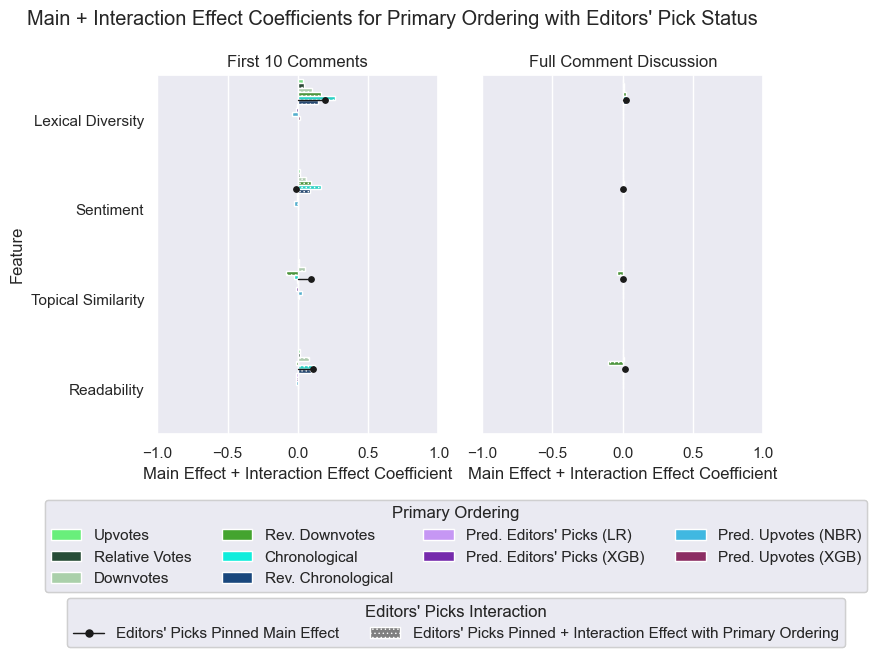

In [14]:
# Plot interaction effects

barsdict = {}
shift = 0.35
fig, axs = plt.subplots(1, 2, figsize=(8, 5), sharey=True)
for n, (ncomments, pdictn) in enumerate(pdictr.items()):
    ax = axs[n]
    pdf = pdictn['coef']
    pdfm = pdf[(pdf['index']!='(Intercept)')&(~pdf['index'].str.contains(':'))]
    pdf = pdf[(pdf['index']!='(Intercept)')&(pdf['index'].str.contains(':'))]
    pdf['policy'] = pdf['index'].str.split(':').str[0].map(polnames)
    pdf['interaction'] = pdf['index'].str.split(':').str[1].map(polnames)
    pdf = pdf.set_index(['policy', 'interaction']).loc[prodorder].reset_index()
    pn = pdictn['coef'].rename(columns={'index': 'policy'})
    pnn = (pn[pn['policy'].isin(polorder[-3:])].rename(
        columns={'policy': 'interaction'}).set_index(['interaction', 'variable'])['value']
        + pdf.set_index(['policy', 'interaction', 'variable'])['value']).reset_index()

    pvdf = pdictn['pv']
    pvdf = pvdf[(pvdf['index']!='(Intercept)')&(pvdf['index'].str.contains(':'))]
    pvdf['policy'] = pvdf['index'].str.split(':').str[0].map(polnames)
    pvdf['interaction'] = pvdf['index'].str.split(':').str[1].map(polnames)
    pvdf = pvdf.set_index(['policy', 'interaction']).loc[prodorder].reset_index()
    
    figt, axt = plt.subplots(1, 1, figsize=(10, 10))
    pnni = pnn[pnn['interaction'] == 'Editors\' Picks Pinned']
    sns.barplot(data=pnni, x='value', y='variable', hue='policy', palette=pal,
                hue_order=polorder[:-3], hatch='....', width=0.9, ax=axt)

    axt.get_legend().remove()
    bars = [mpatches.Rectangle((bar.get_x(), bar.get_y() + math.floor(nbar/10) - 0.45), bar.get_width(), bar.get_height(), 
                                    fc=bar.get_facecolor(), hatch=bar.get_hatch())
                                    for nbar, bar in enumerate(sorted(sum([axt.get_children().copy()[8*n:8*n+4] for n in range(10)], []), key = lambda x: x.get_y()))]

    plt.close()

    # fig, ax = plt.subplots(1, 1, figsize=(10, 15))
    for bar in bars:
        ax.add_patch(bar)    

    ax.set_xticks(np.arange(-1.5, 1.5, 0.5))
    # set yticklabels
    ax.set_yticks(range(0,8,2), labels=featorder)
    # remove y gridlines
    ax.yaxis.grid(False)


    for f in featorder:
        main = pn[(pn['policy'] == 'Editors\' Picks Pinned')&(pn['variable'] == f)]['value'].iloc[0]
        yy = 2*featorder.index(f) - 0.45
        ax.plot((0, main), (yy, yy),
                color='k', lw=1, alpha=1)
        ax.scatter((main,), (yy,),
                color='k', alpha=1, s=15, marker='o')

    ax.set_xlim(-1, 1)
    ax.set_ylim(7, -1)
    ax.set_xlabel('Main Effect + Interaction Effect Coefficient')
    ax.set_title(titles[ncomments])

# create colour legend
handles = [mpatches.Patch(facecolor=pal[i]) for i in range(12)]
labels = polorder[:-3]
l1 = fig.legend(handles, labels, title='Primary Ordering', loc='lower center', ncols=4,
                bbox_to_anchor=(0.58, -0.2))

# add hatch legend
handles = [mlines.Line2D([], [], color='k', marker='o', ms=5, lw=1), mpatches.Patch(facecolor='grey', hatch='....')]
labels = ['Editors\' Picks Pinned Main Effect',
          'Editors\' Picks Pinned + Interaction Effect with Primary Ordering']
l2 = fig.legend(handles, labels, title='Editors\' Picks Interaction',  ncols=2, loc='lower center',
                bbox_to_anchor=(0.58, -0.31))

# add both legends to the same axes
ax.add_artist(l1)
ax.add_artist(l2)
axs[0].set_ylabel('Feature')

fig.suptitle('Main + Interaction Effect Coefficients for Primary Ordering with Editors\' Pick Status')
fig.tight_layout()
plt.savefig('figs/pin_int_coef.pdf', bbox_inches='tight')
plt.savefig('figs/pin_int_coef.svg', bbox_inches='tight')
fig.show()

/var/folders/3m/k3bhjj_54975gvpvvrkv8x6w0000gn/T/ipykernel_28682/319210420.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


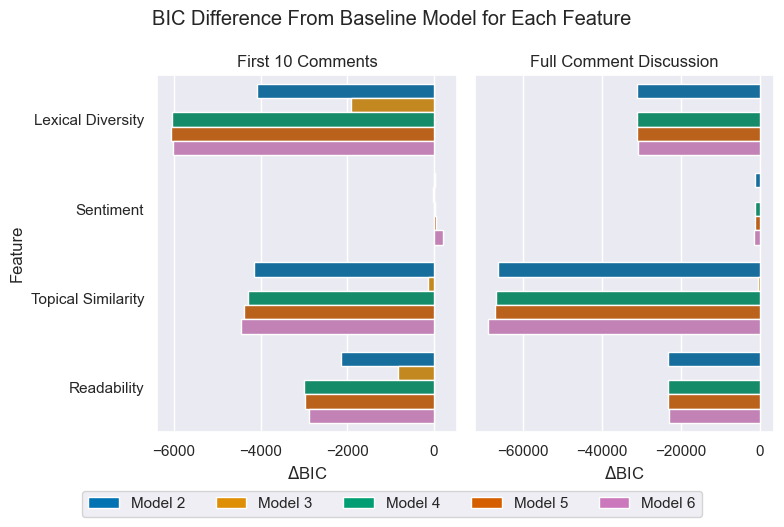

In [10]:
# plot BIC data
bics = pd.read_csv('model_output/bic_table.csv', index_col=0)
bics.columns = ['Feature', 'n', 1, 2, 3, 4, 5, 6]
bics['Feature'] = bics['Feature'].map(featnames)
for n in range(2,7):
    bics[n] = bics[n] - bics[1]

bicslong = bics.melt(id_vars=['Feature', 'n'], var_name='Model', value_name='BIC')
bicslong = bicslong[bicslong['Model'] != 1]

fig, axs = plt.subplots(1, 2, figsize=(8, 5), sharey=True)

sns.barplot(data=bicslong[bicslong['n']=='10'], x='BIC', y='Feature', hue='Model',
            palette='colorblind', ax=axs[0], legend=False)
sns.barplot(data=bicslong[bicslong['n']=='N'], x='BIC', y='Feature', hue='Model',
            palette='colorblind', ax=axs[1], legend=False)
axs[0].set_title('First 10 Comments')
axs[1].set_title('Full Comment Discussion')
axs[0].set_xlabel(r'$\Delta$BIC')
axs[1].set_xlabel(r'$\Delta$BIC')
fig.suptitle('BIC Difference From Baseline Model for Each Feature')

# create figure legend
handles = [mpatches.Patch(facecolor=sns.color_palette("colorblind")[i]) for i in range(5)]
labels = ['Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6']
fig.legend(handles, labels, loc='lower center', ncols=6, bbox_to_anchor=(0.5, -0.05))
fig.tight_layout()
plt.savefig('figs/BICdiffs.pdf', bbox_inches='tight')
plt.savefig('figs/BICdiffs.svg', bbox_inches='tight')
fig.show()


In [11]:
bics = pd.read_csv('model_output/bic_table.csv', index_col=0)
bics.columns = ['Feature', 'n', 1, 2, 3, 4, 5, 6]
bics['Feature'] = bics['Feature'].map(featnames)
bics[list(range(1,7))] = bics[range(1,7)].astype(int)
bics


,Feature,n,1,2,3,4,5,6
1,Lexical Diversity,10,-288796,-292887,-290700,-294836,-294867,-294822
2,Sentiment,10,-170377,-170345,-170390,-170358,-170339,-170166
3,Topical Similarity,10,-148677,-152821,-148822,-152963,-153059,-153135
4,Readability,10,-321775,-323927,-322600,-324763,-324758,-324646
5,Lexical Diversity,N,-507087,-538298,-507043,-538269,-538260,-538039
6,Sentiment,N,-575856,-577116,-575925,-577187,-577198,-577299
7,Topical Similarity,N,-442190,-508419,-442621,-509120,-509382,-511008
8,Readability,N,-558329,-581645,-558244,-581565,-581547,-581315


In [37]:
def forum_change(x):
    return (np.exp(x) - 1)/(np.exp(x) + 1)

x = 0.359461626955409
forum_change(x)

0.17782020576312435